# Reprezentacja grafowa obrazu #
Plan:

1. Wczytywanie obrazu.

2. Transformacja do grafu.

3. Wizualizacja za pomocą programu *graphviz*.

## Import bibliotek##

In [1]:
from PIL import Image
import numpy as np
import networkx as nx
from graphviz import Graph
from random import random

## 1. Wczytywanie obrazu ##

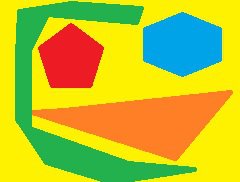

In [2]:
hen = Image.open("./my2.jpg")
hen

Teraz należy przekształcić obraz do postaci macierzy $x \times y \times 3$. Jej elementami będą wartości poszczególnych pikseli. Zauważmy, że jest to macierz 3-wymiarowa - ostatni wymiar odpowiada warstwom *RGB*. 

In [3]:
#hen = hen.resize((64,64))
image_arr = np.array(hen, dtype='int16')
image_arr.shape

(182, 240, 3)

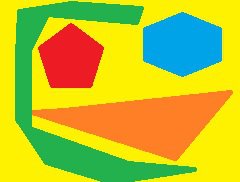

In [4]:
hen


## 2. Transformacja do grafu ##

In [5]:
G = nx.Graph()

Definiowanie zbiorów wierzchołków grafu

In [6]:
width=image_arr.shape[0]
height=image_arr.shape[1]

In [7]:
for i in range(width):
    for j in range(height):
        G.add_node((i,j))

# (*) ustalamy czy chcemy 8 (true) czy 4 (false) sąsiadów

In [8]:
edges_8=True

# (*) ustalamy metrykę do liczenia odległości między pikselami

In [9]:
def diff(image_arr, x1, y1, x2, y2):
    _out = np.sum((image_arr[x1, y1] - image_arr[x2, y2]) ** 2)
    return np.sqrt(_out)

Definiowanie zbiorów krawędzi grafu 

In [10]:
for y in range(height):
        for x in range(width):
            if x > 0:
                G.add_edge((x,y),(x-1,y),weight=diff(image_arr,x,y,x-1,y))

            if y > 0:
                G.add_edge((x,y),(x,y-1),weight=diff(image_arr,x,y,x,y-1))

            if edges_8:
                if x > 0 and y > 0:
                    G.add_edge((x,y),(x-1,y-1),weight=diff(image_arr,x,y,x-1,y-1))

                if x > 0 and y <width-1:
                    G.add_edge((x,y),(x-1,y+1),weight=diff(image_arr,x,y,x-1,y+1))
           

C:\Users\E6420\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


# 3. Algorytm oparty na MST

Sortujemy krawędzie

In [11]:
sorted_edges=sorted(G.edges(data=True),key=lambda e: e[2]['weight'])

Definiujemy klasy pomocnicze (wierzchołek i las)

In [12]:
class Node:
    def __init__(self, parent, rank=0, size=1):
        self.parent = parent
        self.rank = rank
        self.size = size

In [13]:
class Forest:
    def __init__(self, num_nodes):
        self.nodes = [Node(i) for i in range(num_nodes)]
        self.num_sets = num_nodes

    def size_of(self, i):
        return self.nodes[i].size

    def find(self, n):
        temp = n
        while temp != self.nodes[temp].parent:
            temp = self.nodes[temp].parent

        self.nodes[n].parent = temp
        return temp

    def merge(self, a, b):
        if self.nodes[a].rank > self.nodes[b].rank:
            self.nodes[b].parent = a
            self.nodes[a].size = self.nodes[a].size + self.nodes[b].size
        else:
            self.nodes[a].parent = b
            self.nodes[b].size = self.nodes[b].size + self.nodes[a].size

            if self.nodes[a].rank == self.nodes[b].rank:
                self.nodes[b].rank = self.nodes[b].rank + 1

        self.num_sets = self.num_sets - 1
        


In [14]:
forest = Forest(width*height)

In [15]:
vertex_id = lambda x, y: y * width + x

# (*) funkcja progowa do MST (aby drzewa nie były zbyt duże), zarówno stała jak i cała funkcja może byc parametrem

In [16]:
def threshold(size, const):
    return (const *1.0 / size)

In [17]:
const=20.0

In [18]:
Threshold = [ threshold(1, const) for _ in range(width*height) ]

In [19]:
for e in sorted_edges:
        parent_a = forest.find(vertex_id(e[0][0],e[0][1]))
        parent_b = forest.find(vertex_id(e[1][0],e[1][1]))
        a_condition = e[2]['weight'] <= Threshold[parent_a]
        b_condition = e[2]['weight'] <= Threshold[parent_b]
        
        if parent_a != parent_b and a_condition and b_condition:
            forest.merge(parent_a, parent_b)
            a = forest.find(parent_a)
            Threshold[a] = e[2]['weight'] + threshold(forest.nodes[a].size, const)

# (*) ustalamy minimalną liczbę pikseli w elemencie (algorytm zdecydowanie do poprawy, brak kryterium pozbywania się małych elementów)

In [37]:
min_size=2500

In [38]:
for e in sorted_edges:
        a = forest.find(vertex_id(e[0][0],e[0][1]))
        b = forest.find(vertex_id(e[1][0],e[1][1]))

        if a != b and (forest.size_of(a) < min_size or forest.size_of(b) < min_size):
            forest.merge(a, b)

In [39]:
forest.num_sets

9

# 4. Generujemy obraz z otrzymanego lasu

In [40]:
random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
colors = [random_color() for i in range(width*height)]
img = Image.new('RGB', (width, height))
im = img.load()
for y in range(height):
    for x in range(width):
        comp = forest.find(y * width + x)
        im[x, y] = colors[comp]


In [41]:
img=img.transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

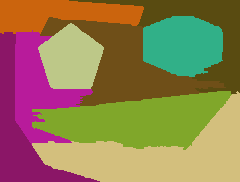

In [42]:
img